## Train-test-split, parameter tuning, cross validation, final testing with SMOTE oversampling

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import UndefinedMetricWarning, FitFailedWarning
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
warnings.filterwarnings(action='ignore', category=FitFailedWarning)

np.random.seed(42)

### Train test split

In [2]:
def split(source_file):
    df = pd.read_csv(source_file)
    X = df.drop(['literature_review'], axis=1)
    y = df['literature_review']
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.25, random_state=42)
    return X_train, X_test, y_train, y_test

### Parameter tuning and testing
- various parameters are tested for each algorithm using sklearn's GridSearchCV
- the parameters are evaluated using cross validation, the training set is oversampled with smote in each iteration
- the best parameters are used for training the model
- the training data is oversampled
- the model is then tested on the testing data

In [3]:
def tune_params(X_train,y_train,X_test,y_test,pipeline,params):
    grid_search = GridSearchCV(estimator=pipeline, param_grid=params, scoring=['f1','recall','precision'],cv=5, refit='f1')
    over = SMOTE()
    over_X, over_y = over.fit_resample(X_train, y_train)
    grid_search.fit(over_X, over_y)
    y_pred = grid_search.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print(f"     f1: {f1}\n     recall: {recall}\n      precision: {precision}")
    return f1, recall, precision

def train_and_test(source_path):
    X_train, X_test, y_train, y_test = split(source_path)
    f1_scores = {}
    recall_scores = {}
    precision_scores = {}

    # Logistic Regression
    lr_pipeline = imbpipeline([('sampling', SMOTE()),('scaler', StandardScaler()),('lr', LogisticRegression(max_iter=200))])
    lr_params = {'lr__penalty':['l1','l2'], 
                'lr__C':[1, 10, 100, 1000],
                'lr__class_weight': [None, 'balanced']}
    print('Logistic Regression:')
    f1, recall, precision = tune_params(X_train, y_train, X_test, y_test, lr_pipeline, lr_params)
    f1_scores['LR'] = f1
    recall_scores['LR'] = recall
    precision_scores['LR'] = precision
    
    # Support Vector Machines
    svm_pipeline = imbpipeline([('sampling', SMOTE()),('scaler', StandardScaler()),('svm', SVC())])
    svm_params = {'svm__C': [0.1, 1, 10],  
                'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                'svm__kernel': ['rbf'],
                'svm__class_weight': [None, 'balanced']}
    print('Support Vector Machines:')
    f1, recall, precision = tune_params(X_train, y_train, X_test, y_test, svm_pipeline, svm_params)
    f1_scores['SVM'] = f1
    recall_scores['SVM'] = recall
    precision_scores['SVM'] = precision

    # Naive Bayes without parameter optimization
    nb = GaussianNB()
    oversample = SMOTE()
    over_X, over_y = oversample.fit_resample(X_train, y_train)
    nb.fit(over_X, over_y)
    y_pred = nb.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print('Naive Bayes:')
    print(f"     f1: {f1}\n     recall: {recall}\n      precision: {precision}")
    f1_scores['NB'] = f1
    recall_scores['NB'] = recall
    precision_scores['NB'] = precision

    # Decision Trees
    dt_pipeline = imbpipeline([('sampling', SMOTE()),('dt', DecisionTreeClassifier())])
    dt_params = {'dt__criterion': ['gini', 'entropy'], 
                'dt__max_depth':range(1,10),
                'dt__class_weight': [None, 'balanced']}
    print('Decision Trees:')
    f1, recall, precision = tune_params(X_train, y_train, X_test, y_test, dt_pipeline, dt_params)
    f1_scores['DT'] = f1
    recall_scores['DT'] = recall
    precision_scores['DT'] = precision

    # Random Forest
    rf_pipeline = imbpipeline([('sampling', SMOTE()),('rf', RandomForestClassifier())])
    rf_params = {'rf__bootstrap': [True, False],
                 'rf__max_depth': [3, 6, 9, None],
                 'rf__max_features': ['auto', 'sqrt'],
                 'rf__n_estimators': [25, 50, 100, 150],
                 'rf__class_weight': [None, 'balanced']}
    print(f'Random Forest:')
    f1, recall, precision = tune_params(X_train, y_train, X_test, y_test, rf_pipeline, rf_params)
    f1_scores['RF'] = f1
    recall_scores['RF'] = recall
    precision_scores['RF'] = precision

    # k-nearest neighbor
    knn_pipeline = imbpipeline([('sampling', SMOTE()),('scaler', StandardScaler()),('knn', KNeighborsClassifier())])
    knn_params = {'knn__n_neighbors': range(1,10),  
                'knn__weights': ['uniform', 'distance']}
    print(f'K-nearest neighbor:')
    f1, recall, precision = tune_params(X_train, y_train, X_test, y_test, knn_pipeline, knn_params)
    f1_scores['kNN'] = f1
    recall_scores['kNN'] = recall
    precision_scores['kNN'] = precision
    
    # Balanced Random Forest
    brf_pipeline = imbpipeline([('sampling', SMOTE()),('brf', BalancedRandomForestClassifier())])
    brf_params = {'brf__bootstrap': [True, False],
                 'brf__max_depth': [3, 6, 9, None],
                 'brf__max_features': ['auto', 'sqrt'],
                 'brf__n_estimators': [25, 50, 100, 150],
                 'brf__class_weight': [None, 'balanced']}
    print(f'Balanced Random Forest:')
    f1, recall, precision = tune_params(X_train, y_train, X_test, y_test, brf_pipeline, brf_params)
    f1_scores['BRF'] = f1
    recall_scores['BRF'] = recall
    precision_scores['BRF'] = precision
    
    return f1_scores, recall_scores, precision_scores


### Graph for visualizing the results

In [4]:
def make_graph(f1, recall, precision):
    
    del f1['NB']
    del f1['kNN']
    del recall['NB']
    del recall['kNN']
    del precision['NB']
    del precision['kNN']
    
    plt.figure(figsize=(8,6))
    plt.bar(x=[0,5,10,15,20], height=list(f1.values()), width=0.9, color="tomato", label="f1")
    plt.bar(x=[1,6,11,16,21], height=list(precision.values()), width=0.9, color="dodgerblue", label="precision")
    plt.bar(x=[2,7,12,17,22], height=list(recall.values()), width=0.9, color="lime", label="recall")

    plt.xlabel("algorithm")
    plt.ylabel("metric score")

    plt.xticks(ticks=[1.5, 6.5, 11.5, 16.5, 21.5], labels=list(f1.keys()), rotation=45)
    plt.legend(loc='best')
    plt.show()

### All feature combinations are tested on both datasets

- - - original dataset, keywords feature - - -
Logistic Regression:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.45503183        nan 0.45503183        nan 0.45524632
        nan 0.45524632        nan 0.45498401        nan 0.45498401
        nan 0.45519793        nan 0.45519793]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.30460317        nan 0.30460317        nan 0.30460317
        nan 0.30460317        nan 0.30397026        nan 0.30397026
        nan 0.30397026        nan 0.30397026]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.90190265        nan 0.90190265        nan 0.90347922
        nan 0.90347922        nan 0.90689589        nan 0.90689589
        nan 0.90885036      

     f1: 0.3181818181818182
     recall: 0.4375
      precision: 0.25
Support Vector Machines:
     f1: 0.07407407407407407
     recall: 0.8125
      precision: 0.03880597014925373
Naive Bayes:
     f1: 0.05871559633027523
     recall: 1.0
      precision: 0.030245746691871456
Decision Trees:
     f1: 0.11049723756906077
     recall: 0.625
      precision: 0.06060606060606061
Random Forest:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.446993   0.44977588
 0.45019767 0.45019767        nan        nan        nan        nan
 0.44987716 0.44967341 0.44967341 0.44967341        nan        nan
        nan        nan 0.47992654 0.44967341 0.44967341 0.44987716
        nan        nan        nan        nan 0.48057741 0.48037366
 0.54142695 0.51137757        nan        nan        nan        nan
 0.44976472 0.45019336 0.45019767 0.44977588        nan        nan
        nan        nan 0.44987716 0.44967341 0.44967341 0.44967341
        nan        nan        nan        nan 0.51093045 0.48067732
 0.44967341 0.44967341        nan        nan        nan        nan
 0.54142695 0.51137757 0.54142695 0.51137757        nan        nan
        nan        nan 0.44925184 0.45019767 0.44976046 0.44998174
        nan        nan        nan        nan 0.4

     f1: 0.34146341463414637
     recall: 0.4375
      precision: 0.28
K-nearest neighbor:
     f1: 0.25
     recall: 0.1875
      precision: 0.375
Balanced Random Forest:


/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.


     f1: 0.3181818181818182
     recall: 0.4375
      precision: 0.25


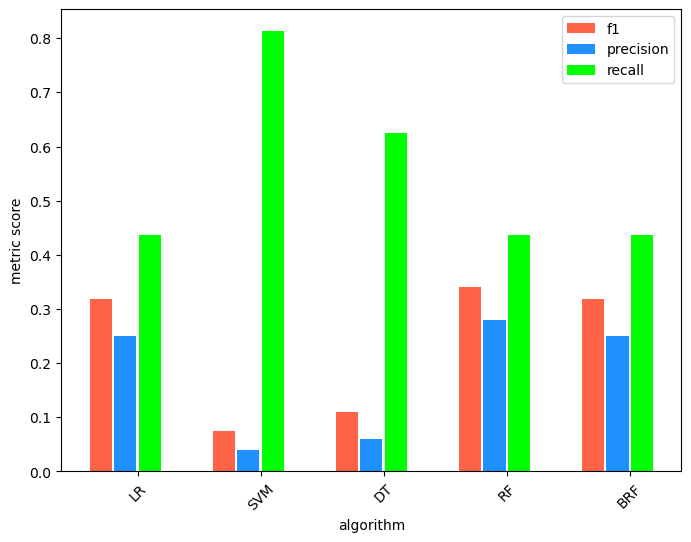

- - - original dataset, references feature - - -
Logistic Regression:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.45757236        nan 0.45757236        nan 0.45777822
        nan 0.45777822        nan 0.45746889        nan 0.45746889
        nan 0.45768795        nan 0.45768795]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.30653607        nan 0.30653607        nan 0.30653607
        nan 0.30653607        nan 0.30590315        nan 0.30590315
        nan 0.30590315        nan 0.30590315]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.90390015        nan 0.90390015        nan 0.90556681
        nan 0.90556681        nan 0.90897945        nan 0.90897945
        nan 0.91086064      

     f1: 0.3181818181818182
     recall: 0.4375
      precision: 0.25
Support Vector Machines:
     f1: 0.07449856733524356
     recall: 0.8125
      precision: 0.03903903903903904
Naive Bayes:
     f1: 0.05871559633027523
     recall: 1.0
      precision: 0.030245746691871456
Decision Trees:
     f1: 0.32558139534883723
     recall: 0.4375
      precision: 0.25925925925925924
Random Forest:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.4547333  0.45488384
 0.45512584 0.45539731        nan        nan        nan        nan
 0.45446396 0.45492913 0.45470611 0.45492913        nan        nan
        nan        nan 0.47449019 0.47447401 0.50704111 0.47469704
        nan        nan        nan        nan 0.50726414 0.50704111
 0.50704111 0.50726414        nan        nan        nan        nan
 0.45495632 0.45488384 0.45493119 0.45488384        nan        nan
        nan        nan 0.47447401 0.45470611 0.45492913 0.45492913
        nan        nan        nan        nan 0.45492913 0.47447401
 0.47469704 0.47447401        nan        nan        nan        nan
 0.47469704 0.47469704 0.50704111 0.50726414        nan        nan
        nan        nan 0.45488384 0.45512584 0.45512584 0.45534886
        nan        nan        nan        nan 0.4

     f1: 0.3333333333333333
     recall: 0.4375
      precision: 0.2692307692307692
K-nearest neighbor:
     f1: 0.25
     recall: 0.1875
      precision: 0.375
Balanced Random Forest:


/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.


     f1: 0.3181818181818182
     recall: 0.4375
      precision: 0.25


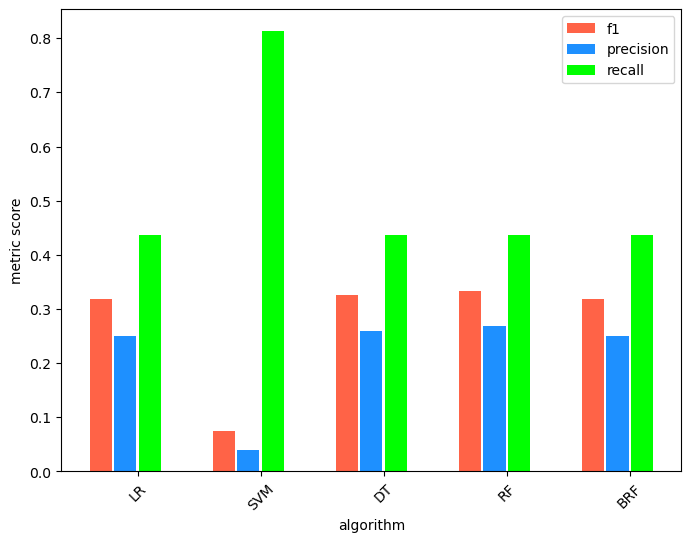

- - - original dataset, text mining feature - - -
Logistic Regression:


/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

     f1: 0.13333333333333333
     recall: 0.3125
      precision: 0.0847457627118644
Support Vector Machines:


/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

     f1: 0.125
     recall: 0.1875
      precision: 0.09375
Naive Bayes:
     f1: 0.08333333333333333
     recall: 0.3125
      precision: 0.04807692307692308
Decision Trees:


/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

     f1: 0.1509433962264151
     recall: 0.5
      precision: 0.08888888888888889
Random Forest:


/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

     f1: 0.1016949152542373
     recall: 0.1875
      precision: 0.06976744186046512
K-nearest neighbor:


/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

     f1: 0.0975609756097561
     recall: 0.25
      precision: 0.06060606060606061
Balanced Random Forest:


/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

     f1: 0.1016949152542373
     recall: 0.1875
      precision: 0.06976744186046512


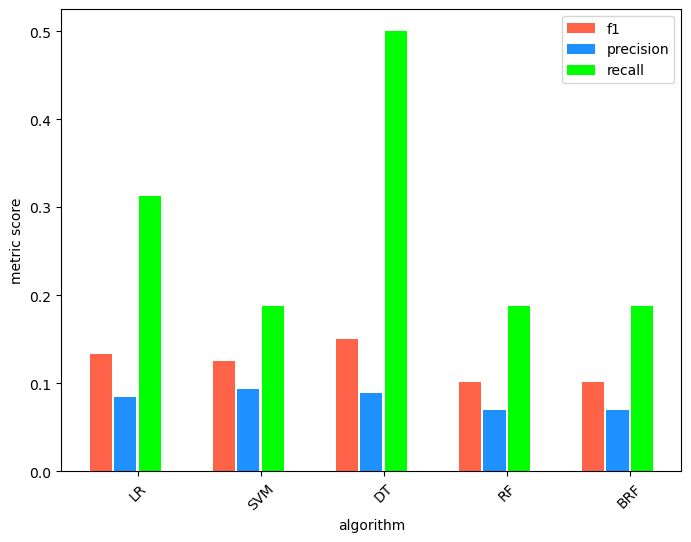

- - - extended dataset, keywords feature - - -
Logistic Regression:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.53704224        nan 0.53704224        nan 0.53883159
        nan 0.53857156        nan 0.53961722        nan 0.53961722
        nan 0.53961652        nan 0.53961652]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.38340667        nan 0.38340667        nan 0.38340667
        nan 0.38340667        nan 0.38340667        nan 0.38340667
        nan 0.38340667        nan 0.38340667]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.89704344        nan 0.89704344        nan 0.90713515
        nan 0.90562344        nan 0.91130469        nan 0.91130469
        nan 0.91127355      

     f1: 0.32558139534883723
     recall: 0.45161290322580644
      precision: 0.2545454545454545
Support Vector Machines:
     f1: 0.06126482213438735
     recall: 1.0
      precision: 0.03160040774719674
Naive Bayes:
     f1: 0.06126482213438735
     recall: 1.0
      precision: 0.03160040774719674
Decision Trees:
     f1: 0.3218390804597701
     recall: 0.45161290322580644
      precision: 0.25
Random Forest:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.5365633  0.53526811
 0.53489058 0.53513249        nan        nan        nan        nan
 0.53987883 0.53951483 0.53924722 0.53962834        nan        nan
        nan        nan 0.53964436 0.53987883 0.53950983 0.53950983
        nan        nan        nan        nan 0.53987883 0.53950983
 0.53950983 0.53987883        nan        nan        nan        nan
 0.53513295 0.53539173 0.53527521 0.53502351        nan        nan
        nan        nan 0.53938143 0.53851952 0.53938804 0.53851952
        nan        nan        nan        nan 0.53987883 0.53950983
 0.53950983 0.53950983        nan        nan        nan        nan
 0.53950983 0.54001336 0.53987883 0.53950983        nan        nan
        nan        nan 0.53488075 0.53526209 0.53540845 0.53525819
        nan        nan        nan        nan 0.5

     f1: 0.30952380952380953
     recall: 0.41935483870967744
      precision: 0.24528301886792453
K-nearest neighbor:
     f1: 0.0625
     recall: 0.03225806451612903
      precision: 1.0
Balanced Random Forest:


/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.


     f1: 0.30952380952380953
     recall: 0.41935483870967744
      precision: 0.24528301886792453


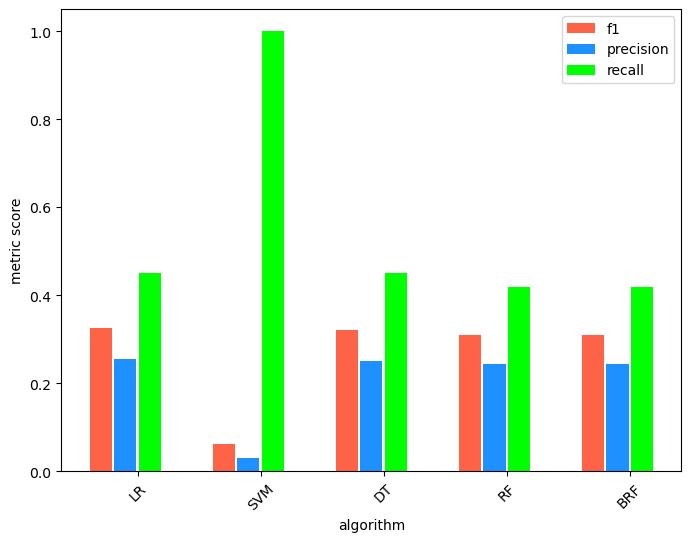

- - - extended dataset, references feature - - -
Logistic Regression:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.54197386        nan 0.54197386        nan 0.54378414
        nan 0.54378414        nan 0.54454186        nan 0.54467096
        nan 0.54454186        nan 0.54454186]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.38817089        nan 0.38817089        nan 0.38817089
        nan 0.38817089        nan 0.38817089        nan 0.38817089
        nan 0.38817089        nan 0.38817089]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.89891493        nan 0.89891493        nan 0.90884031
        nan 0.90884031        nan 0.91324828        nan 0.91396351
        nan 0.91324828      

     f1: 0.3181818181818182
     recall: 0.45161290322580644
      precision: 0.24561403508771928
Support Vector Machines:
     f1: 0.06126482213438735
     recall: 1.0
      precision: 0.03160040774719674
Naive Bayes:
     f1: 0.05771144278606965
     recall: 0.9354838709677419
      precision: 0.029774127310061602
Decision Trees:
     f1: 0.3181818181818182
     recall: 0.45161290322580644
      precision: 0.24561403508771928
Random Forest:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.5317802  0.53164628
 0.53177916 0.53165857        nan        nan        nan        nan
 0.53631384 0.53517838 0.53468442 0.53512           nan        nan
        nan        nan 0.53859684 0.53789187 0.53859684 0.53859684
        nan        nan        nan        nan 0.53895608 0.53859684
 0.53859684 0.53859684        nan        nan        nan        nan
 0.53152968 0.53162734 0.53152945 0.53179445        nan        nan
        nan        nan 0.53362641 0.53528935 0.53516576 0.53588786
        nan        nan        nan        nan 0.53787576 0.53836401
 0.53859684 0.53859684        nan        nan        nan        nan
 0.53859684 0.53859684 0.53859684 0.53859684        nan        nan
        nan        nan 0.53204454 0.53216101 0.53166001 0.53190731
        nan        nan        nan        nan 0.5

     f1: 0.32608695652173914
     recall: 0.4838709677419355
      precision: 0.2459016393442623
K-nearest neighbor:
     f1: 0.1951219512195122
     recall: 0.12903225806451613
      precision: 0.4
Balanced Random Forest:


/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.


     f1: 0.32608695652173914
     recall: 0.4838709677419355
      precision: 0.2459016393442623


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.52484396 0.52489837
 0.52451763 0.52413972        nan        nan        nan        nan
 0.52894896 0.52823315 0.52932837 0.52913406        nan        nan
        nan        nan 0.53149425 0.53075046 0.53040393 0.53080037
        nan        nan        nan        nan 0.53183995 0.53183995
 0.53183995 0.53183995        nan        nan        nan        nan
 0.52484646 0.52476926 0.52439739 0.52451532        nan        nan
        nan        nan 0.52921516 0.52913406 0.52871357 0.5291125
        nan        nan        nan        nan 0.5297084  0.53149425
 0.53149425 0.53149425        nan        nan        nan        nan
 0.53149425 0.53183995 0.53183995 0.53183995        nan        nan
        nan        nan 0.52475461 0.52464214 0.52440487 0.52414491
        nan        nan        nan        nan 0.52

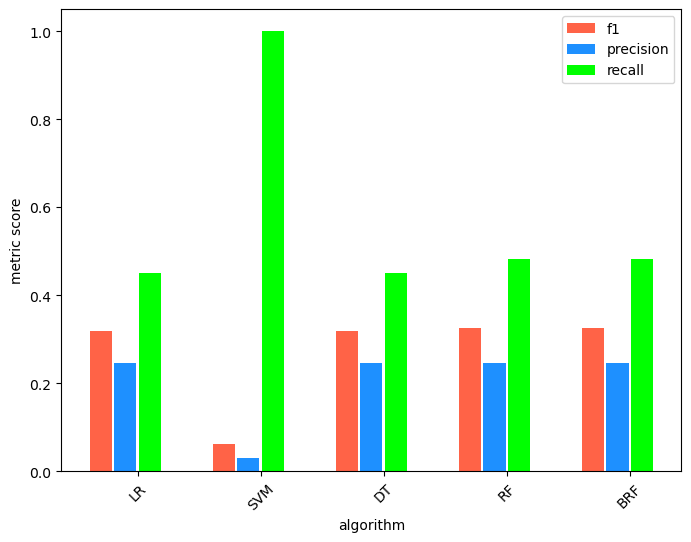

- - - extended dataset, text mining feature - - -
Logistic Regression:


/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

     f1: 0.16541353383458646
     recall: 0.3548387096774194
      precision: 0.10784313725490197
Support Vector Machines:


/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

     f1: 0.06818181818181818
     recall: 0.0967741935483871
      precision: 0.05263157894736842
Naive Bayes:
     f1: 0.12056737588652482
     recall: 0.5483870967741935
      precision: 0.06772908366533864
Decision Trees:


/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

     f1: 0.20606060606060606
     recall: 0.5483870967741935
      precision: 0.12686567164179105
Random Forest:


/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

     f1: 0.16216216216216217
     recall: 0.2903225806451613
      precision: 0.1125
K-nearest neighbor:


/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

     f1: 0.12878787878787878
     recall: 0.5483870967741935
      precision: 0.07296137339055794
Balanced Random Forest:


/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/luca/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

     f1: 0.17543859649122806
     recall: 0.3225806451612903
      precision: 0.12048192771084337


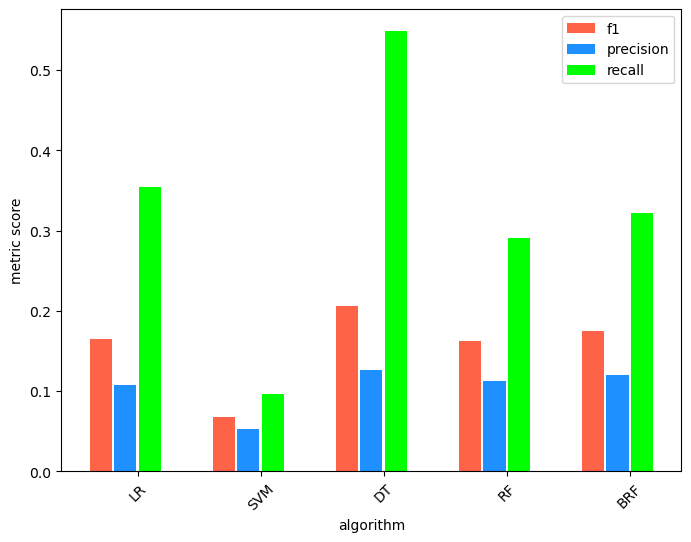

In [5]:
print("- - - original dataset, keywords feature - - -")
f1_scores, recall_scores, precision_scores = train_and_test("../../data/processed/original_dataset/data_key.csv")
make_graph(f1_scores, recall_scores, precision_scores)

print("- - - original dataset, references feature - - -")
f1_scores, recall_scores, precision_scores = train_and_test("../../data/processed/original_dataset/data_ref.csv")
make_graph(f1_scores, recall_scores, precision_scores)

print("- - - original dataset, text mining feature - - -")
f1_scores, recall_scores, precision_scores = train_and_test("../../data/processed/original_dataset/data_tm.csv")
make_graph(f1_scores, recall_scores, precision_scores)

print("- - - extended dataset, keywords feature - - -")
f1_scores, recall_scores, precision_scores = train_and_test("../../data/processed/extended_dataset/data_key.csv")
make_graph(f1_scores, recall_scores, precision_scores)

print("- - - extended dataset, references feature - - -")
f1_scores, recall_scores, precision_scores = train_and_test("../../data/processed/extended_dataset/data_ref.csv")
make_graph(f1_scores, recall_scores, precision_scores)

print("- - - extended dataset, text mining feature - - -")
f1_scores, recall_scores, precision_scores = train_and_test("../../data/processed/extended_dataset/data_tm.csv")
make_graph(f1_scores, recall_scores, precision_scores)